# --- Day 22: Mode Maze ---

This is it, your final stop: the year -483. It's snowing and dark outside; the only light you can see is coming from a small cottage in the distance. You make your way there and knock on the door.

A portly man with a large, white beard answers the door and invites you inside. For someone living near the North Pole in -483, he must not get many visitors, but he doesn't act surprised to see you. Instead, he offers you some milk and cookies.

After talking for a while, he asks a favor of you. His friend hasn't come back in a few hours, and he's not sure where he is. Scanning the region briefly, you discover one life signal in a cave system nearby; his friend must have taken shelter there. The man asks if you can go there to retrieve his friend.

The cave is divided into square regions which are either dominantly rocky, narrow, or wet (called its type). Each region occupies exactly one coordinate in X,Y format where X and Y are integers and zero or greater. (Adjacent regions can be the same type.)

The scan (your puzzle input) is not very detailed: it only reveals the depth of the cave system and the coordinates of the target. However, it does not reveal the type of each region. The mouth of the cave is at 0,0.

The man explains that due to the unusual geology in the area, there is a method to determine any region's type based on its erosion level. The erosion level of a region can be determined from its geologic index. The geologic index can be determined using the first rule that applies from the list below:

*    The region at 0,0 (the mouth of the cave) has a geologic index of 0.
*    The region at the coordinates of the target has a geologic index of 0.
*    If the region's Y coordinate is 0, the geologic index is its X coordinate times 16807.
*    If the region's X coordinate is 0, the geologic index is its Y coordinate times 48271.
*    Otherwise, the region's geologic index is the result of multiplying the erosion levels of the regions at X-1,Y and X,Y-1.

A region's erosion level is its geologic index plus the cave system's depth, all modulo 20183. Then:

*    If the erosion level modulo 3 is 0, the region's type is rocky.
*    If the erosion level modulo 3 is 1, the region's type is wet.
*    If the erosion level modulo 3 is 2, the region's type is narrow.

For example, suppose the cave system's depth is 510 and the target's coordinates are 10,10. Using % to represent the modulo operator, the cavern would look as follows:

*    At 0,0, the geologic index is 0. The erosion level is (0 + 510) % 20183 = 510. The type is 510 % 3 = 0, rocky.
*    At 1,0, because the Y coordinate is 0, the geologic index is 1 * 16807 = 16807. The erosion level is (16807 + 510) % 20183 = 17317. The type is 17317 % 3 = 1, wet.
*    At 0,1, because the X coordinate is 0, the geologic index is 1 * 48271 = 48271. The erosion level is (48271 + 510) % 20183 = 8415. The type is 8415 % 3 = 0, rocky.
*    At 1,1, neither coordinate is 0 and it is not the coordinate of the target, so the geologic index is the erosion level of 0,1 (8415) times the erosion level of 1,0 (17317), 8415 * 17317 = 145722555. The erosion level is (145722555 + 510) % 20183 = 1805. The type is 1805 % 3 = 2, narrow.
*    At 10,10, because they are the target's coordinates, the geologic index is 0. The erosion level is (0 + 510) % 20183 = 510. The type is 510 % 3 = 0, rocky.

Drawing this same cave system with rocky as ., wet as =, narrow as |, the mouth as M, the target as T, with 0,0 in the top-left corner, X increasing to the right, and Y increasing downward, the top-left corner of the map looks like this:
```
M=.|=.|.|=.|=|=.
.|=|=|||..|.=...
.==|....||=..|==
=.|....|.==.|==.
=|..==...=.|==..
=||.=.=||=|=..|=
|.=.===|||..=..|
|..==||=.|==|===
.=..===..=|.|||.
.======|||=|=.|=
.===|=|===T===||
=|||...|==..|=.|
=.=|=.=..=.||==|
||=|=...|==.=|==
|=.=||===.|||===
||.|==.|.|.||=||
```
Before you go in, you should determine the risk level of the area. For the rectangle that has a top-left corner of region 0,0 and a bottom-right corner of the region containing the target, add up the risk level of each individual region: 0 for rocky regions, 1 for wet regions, and 2 for narrow regions.

In the cave system above, because the mouth is at 0,0 and the target is at 10,10, adding up the risk level of all regions with an X coordinate from 0 to 10 and a Y coordinate from 0 to 10, this total is 114.

What is the total risk level for the smallest rectangle that includes 0,0 and the target's coordinates?


In [ ]:
from collections import defaultdict, namedtuple
import heapq
import unittest
import re

In [ ]:
test_map = '''M=.|=.|.|=.|=|=.
.|=|=|||..|.=...
.==|....||=..|==
=.|....|.==.|==.
=|..==...=.|==..
=||.=.=||=|=..|=
|.=.===|||..=..|
|..==||=.|==|===
.=..===..=|.|||.
.======|||=|=.|=
.===|=|===T===||
=|||...|==..|=.|
=.=|=.=..=.||==|
||=|=...|==.=|==
|=.=||===.|||===
||.|==.|.|.||=||'''

In [ ]:
class TestP1(unittest.TestCase):
    def setUp(self):
        self.CM = CaveMap(510, (10, 10))
        self.CM.calculate(complex(15, 15))
    
    def test01(self):
        self.assertEqual(self.CM.to_str(), test_map)
        
    def test02(self):
        self.assertEqual(self.CM.risk_level(), 114)


In [ ]:
RWN = list('.=|')

ROCKY, WET, NARROW = RWN

# for part 1
UP = 0 - 1 * 1j
LEFT = -1

#############################
# added for part 2        ===
DOWN = -UP
RIGHT = -LEFT
TORCH, CLIMBING_GEAR, NEITHER = TOOLS = ['torch', 'climbing gear', 'neither']

GEAR_ALLOWED = {ROCKY: (CLIMBING_GEAR, TORCH),
                WET: (CLIMBING_GEAR, NEITHER),
                NARROW: (TORCH, NEITHER)}

TERRAIN_ALLOWED = {tool: tuple(terrain for terrain in GEAR_ALLOWED if tool in GEAR_ALLOWED[terrain]) for tool in TOOLS}

# State defined as a namedtuple causes the heapq methods to barf once more than one item in the queue has the same priority
# since the next level of comparison is on the item, and the complex numbers in State tuple won't compare
# State = namedtuple('State', ['loc', 'tool'])
class State(object):
    
    def __init__(self, loc, tool):
        self.loc = loc
        self.tool = tool
    
    def __repr__(self):
        return f'State({repr(self.loc)},{repr(self.tool)})'
    
    # we need a __hash__ so we can use these as keys in dicts
    def __hash__(self):
        return hash(repr(self))
    
    def __lt__(self, other):
        if self.loc.imag < other.loc.imag:
            return True
        if self.loc.real < other.loc.real:
            return True
        if TOOLS.index(self.tool) < TOOLS.index(other.tool):
            return True
        return False
    
    def __gt__(self, other):
        if self.loc.imag < other.loc.imag:
            return True
        if self.loc.real < other.loc.real:
            return True
        if TOOLS.index(self.tool) < TOOLS.index(other.tool):
            return True
        return False

    def __le__(self, other):
        return not self.__gt__(other)
    
    def __ge__(self, other):
        return not self.__lt__(other)
    
    def __eq__(self, other):
        return self.loc == other.loc and self.tool == other.tool

# end of added for part 2 ===
#############################

XFAC = 16807
YFAC = 48271

EROSION_MOD = 20183

class Region(object):
    
    def __init__(self, geologic_index=None, erosion_level=None):
        self.geologic_index = geologic_index
        self.erosion_level = erosion_level
        
    def __str__(self):
        if self.geologic_index is None:
            return '?'
        else:
            return RWN[self.erosion_level % 3]
    
    __repr__ = __str__
    
class CaveMap(object):
    
    def __init__(self, depth, target): # depth is an int, target is  tuple of ints
        self.depth = depth
        self.target = complex(*target)
        self.regions = defaultdict(Region)
        
    def to_str(self, lower_right=complex(15, 15)):
        rows = []
        for y in range(0, int(lower_right.imag) + 1):
            row = ''
            for x in range(0, int(lower_right.real) + 1):
                if x == 0 and y == 0:
                    row += 'M'
                elif x == int(self.target.real) and y ==int(self.target.imag):
                    row += 'T'
                else:
                    row += str(self.regions[x + y * 1j])
            rows.append(row)
        return '\n'.join(rows)
    
    def boundingbox(self):
        coords = self.regions.keys()
        rmax = max(z.real for z in coords)
        imax = max(z.imag for z in coords)
        return rmax + imax * 1j
    
    def calculate(self, lower_right):
        #count = 0
        for y in range(0, int(lower_right.imag) + 1):
            for x in range(0, int(lower_right.real) + 1):
                coord = x + y * 1j
                if self.regions[coord].geologic_index is None:
                    # only calculate the region if it wasn't already calculated
                    if x == 0 and y == 0:
                        self.regions[coord].geologic_index = 0
                    elif x == int(self.target.real) and y == int(self.target.imag):
                        self.regions[coord].geologic_index = 0
                    else:
                        if y == 0:
                            gi = x * XFAC
                        elif x == 0:
                            gi = y * YFAC
                        else:
                            gi = self.regions[coord + UP].erosion_level * self.regions[coord + LEFT].erosion_level
                        self.regions[coord].geologic_index = gi
                    self.regions[coord].erosion_level = (self.regions[coord].geologic_index + self.depth) % EROSION_MOD
        #print(f'Calculated {count} nodes')
        return self

    def risk_level(self):
        return self._risk_level(self.target)
    
    def _risk_level(self, lower_right):
        rl = 0
        for y in range(0, int(lower_right.imag) + 1):
            for x in range(0, int(lower_right.real) + 1):
                rl += self.regions[x + y * 1j].erosion_level % 3
        return rl
    
    # added for part 2
    def neighbours(self, state):
        if (state.loc + RIGHT + DOWN) not in self.regions:
            self.calculate(state.loc + RIGHT + DOWN) # make sure the map is calculated for all neighbour nodes
            
        directions = [RIGHT, DOWN] # we can always go right or down
        
        if state.loc.real >= 1:
            directions.append(LEFT)
        if state.loc.imag >= 1:
            directions.append(UP)
            
        neighbour_coords = map(lambda direction: state.loc + direction, directions)
        neighbours = []
        
        for n in neighbour_coords:
            if str(self.regions[n]) in TERRAIN_ALLOWED[state.tool]:
                neighbours.append(State(n, state.tool))
            next_tool = [i for i in GEAR_ALLOWED[str(self.regions[state.loc])] if i != state.tool][0]
            neighbours.append(State(state.loc, next_tool))
        return neighbours
        
    def __str__(self):
        return self.to_str()
    
    __repr__ = __str__

# Part 1 tests

In [ ]:
suite = unittest.TestLoader().loadTestsFromTestCase(TestP1)
unittest.TextTestRunner(verbosity=2).run(suite)

# Part 1

In [ ]:
params = open('input.txt').read().splitlines()

def get_ints(s):
    return list(map(int, re.findall(r'-?\d+', s)))

depth = get_ints(params[0])[0]
target = get_ints(params[1])

In [7]:
part1 = CaveMap(depth, target)

risk = part1.calculate(part1.target).risk_level()

print(f'Part1: risk level for caverns with depth={depth} and target={tuple(target)} is: {risk}')

Part1: risk level for caverns with depth=11109 and target=(9, 731) is: 7299


# Part 2

Okay, it's time to go rescue the man's friend.

As you leave, he hands you some tools: a torch and some climbing gear. You can't equip both tools at once, but you can choose to use neither.

Tools can only be used in certain regions:

*    In rocky regions, you can use the climbing gear or the torch. You cannot use neither (you'll likely slip and fall).
*    In wet regions, you can use the climbing gear or neither tool. You cannot use the torch (if it gets wet, you won't have a light source).
*    In narrow regions, you can use the torch or neither tool. You cannot use the climbing gear (it's too bulky to fit).

You start at 0,0 (the mouth of the cave) with the torch equipped and must reach the target coordinates as quickly as possible. The regions with negative X or Y are solid rock and cannot be traversed. The fastest route might involve entering regions beyond the X or Y coordinate of the target.

You can move to an adjacent region (up, down, left, or right; never diagonally) if your currently equipped tool allows you to enter that region. Moving to an adjacent region takes one minute. (For example, if you have the torch equipped, you can move between rocky and narrow regions, but cannot enter wet regions.)

You can change your currently equipped tool or put both away if your new equipment would be valid for your current region. Switching to using the climbing gear, torch, or neither always takes seven minutes, regardless of which tools you start with. (For example, if you are in a rocky region, you can switch from the torch to the climbing gear, but you cannot switch to neither.)

Finally, once you reach the target, you need the torch equipped before you can find him in the dark. The target is always in a rocky region, so if you arrive there with climbing gear equipped, you will need to spend seven minutes switching to your torch.

For example, using the same cave system as above, starting in the top left corner (0,0) and moving to the bottom right corner (the target, 10,10) as quickly as possible, one possible route is as follows, with your current position marked X:

Initially:
```
X=.|=.|.|=.|=|=.
.|=|=|||..|.=...
.==|....||=..|==
=.|....|.==.|==.
=|..==...=.|==..
=||.=.=||=|=..|=
|.=.===|||..=..|
|..==||=.|==|===
.=..===..=|.|||.
.======|||=|=.|=
.===|=|===T===||
=|||...|==..|=.|
=.=|=.=..=.||==|
||=|=...|==.=|==
|=.=||===.|||===
||.|==.|.|.||=||
```
Down:
```
M=.|=.|.|=.|=|=.
X|=|=|||..|.=...
.==|....||=..|==
=.|....|.==.|==.
=|..==...=.|==..
=||.=.=||=|=..|=
|.=.===|||..=..|
|..==||=.|==|===
.=..===..=|.|||.
.======|||=|=.|=
.===|=|===T===||
=|||...|==..|=.|
=.=|=.=..=.||==|
||=|=...|==.=|==
|=.=||===.|||===
||.|==.|.|.||=||
```
Right:
```
M=.|=.|.|=.|=|=.
.X=|=|||..|.=...
.==|....||=..|==
=.|....|.==.|==.
=|..==...=.|==..
=||.=.=||=|=..|=
|.=.===|||..=..|
|..==||=.|==|===
.=..===..=|.|||.
.======|||=|=.|=
.===|=|===T===||
=|||...|==..|=.|
=.=|=.=..=.||==|
||=|=...|==.=|==
|=.=||===.|||===
||.|==.|.|.||=||
```
Switch from using the torch to neither tool:
```
M=.|=.|.|=.|=|=.
.X=|=|||..|.=...
.==|....||=..|==
=.|....|.==.|==.
=|..==...=.|==..
=||.=.=||=|=..|=
|.=.===|||..=..|
|..==||=.|==|===
.=..===..=|.|||.
.======|||=|=.|=
.===|=|===T===||
=|||...|==..|=.|
=.=|=.=..=.||==|
||=|=...|==.=|==
|=.=||===.|||===
||.|==.|.|.||=||
```
Right 3:
```
M=.|=.|.|=.|=|=.
.|=|X|||..|.=...
.==|....||=..|==
=.|....|.==.|==.
=|..==...=.|==..
=||.=.=||=|=..|=
|.=.===|||..=..|
|..==||=.|==|===
.=..===..=|.|||.
.======|||=|=.|=
.===|=|===T===||
=|||...|==..|=.|
=.=|=.=..=.||==|
||=|=...|==.=|==
|=.=||===.|||===
||.|==.|.|.||=||
```
Switch from using neither tool to the climbing gear:
```
M=.|=.|.|=.|=|=.
.|=|X|||..|.=...
.==|....||=..|==
=.|....|.==.|==.
=|..==...=.|==..
=||.=.=||=|=..|=
|.=.===|||..=..|
|..==||=.|==|===
.=..===..=|.|||.
.======|||=|=.|=
.===|=|===T===||
=|||...|==..|=.|
=.=|=.=..=.||==|
||=|=...|==.=|==
|=.=||===.|||===
||.|==.|.|.||=||
```
Down 7:
```
M=.|=.|.|=.|=|=.
.|=|=|||..|.=...
.==|....||=..|==
=.|....|.==.|==.
=|..==...=.|==..
=||.=.=||=|=..|=
|.=.===|||..=..|
|..==||=.|==|===
.=..X==..=|.|||.
.======|||=|=.|=
.===|=|===T===||
=|||...|==..|=.|
=.=|=.=..=.||==|
||=|=...|==.=|==
|=.=||===.|||===
||.|==.|.|.||=||
```
Right:
```
M=.|=.|.|=.|=|=.
.|=|=|||..|.=...
.==|....||=..|==
=.|....|.==.|==.
=|..==...=.|==..
=||.=.=||=|=..|=
|.=.===|||..=..|
|..==||=.|==|===
.=..=X=..=|.|||.
.======|||=|=.|=
.===|=|===T===||
=|||...|==..|=.|
=.=|=.=..=.||==|
||=|=...|==.=|==
|=.=||===.|||===
||.|==.|.|.||=||
```
Down 3:
```
M=.|=.|.|=.|=|=.
.|=|=|||..|.=...
.==|....||=..|==
=.|....|.==.|==.
=|..==...=.|==..
=||.=.=||=|=..|=
|.=.===|||..=..|
|..==||=.|==|===
.=..===..=|.|||.
.======|||=|=.|=
.===|=|===T===||
=|||.X.|==..|=.|
=.=|=.=..=.||==|
||=|=...|==.=|==
|=.=||===.|||===
||.|==.|.|.||=||
```
Right:
```
M=.|=.|.|=.|=|=.
.|=|=|||..|.=...
.==|....||=..|==
=.|....|.==.|==.
=|..==...=.|==..
=||.=.=||=|=..|=
|.=.===|||..=..|
|..==||=.|==|===
.=..===..=|.|||.
.======|||=|=.|=
.===|=|===T===||
=|||..X|==..|=.|
=.=|=.=..=.||==|
||=|=...|==.=|==
|=.=||===.|||===
||.|==.|.|.||=||
```
Down:
```
M=.|=.|.|=.|=|=.
.|=|=|||..|.=...
.==|....||=..|==
=.|....|.==.|==.
=|..==...=.|==..
=||.=.=||=|=..|=
|.=.===|||..=..|
|..==||=.|==|===
.=..===..=|.|||.
.======|||=|=.|=
.===|=|===T===||
=|||...|==..|=.|
=.=|=.X..=.||==|
||=|=...|==.=|==
|=.=||===.|||===
||.|==.|.|.||=||
```
Right 4:
```
M=.|=.|.|=.|=|=.
.|=|=|||..|.=...
.==|....||=..|==
=.|....|.==.|==.
=|..==...=.|==..
=||.=.=||=|=..|=
|.=.===|||..=..|
|..==||=.|==|===
.=..===..=|.|||.
.======|||=|=.|=
.===|=|===T===||
=|||...|==..|=.|
=.=|=.=..=X||==|
||=|=...|==.=|==
|=.=||===.|||===
||.|==.|.|.||=||
```
Up 2:
```
M=.|=.|.|=.|=|=.
.|=|=|||..|.=...
.==|....||=..|==
=.|....|.==.|==.
=|..==...=.|==..
=||.=.=||=|=..|=
|.=.===|||..=..|
|..==||=.|==|===
.=..===..=|.|||.
.======|||=|=.|=
.===|=|===X===||
=|||...|==..|=.|
=.=|=.=..=.||==|
||=|=...|==.=|==
|=.=||===.|||===
||.|==.|.|.||=||
```
Switch from using the climbing gear to the torch:
```
M=.|=.|.|=.|=|=.
.|=|=|||..|.=...
.==|....||=..|==
=.|....|.==.|==.
=|..==...=.|==..
=||.=.=||=|=..|=
|.=.===|||..=..|
|..==||=.|==|===
.=..===..=|.|||.
.======|||=|=.|=
.===|=|===X===||
=|||...|==..|=.|
=.=|=.=..=.||==|
||=|=...|==.=|==
|=.=||===.|||===
||.|==.|.|.||=||
```
This is tied with other routes as the fastest way to reach the target: 45 minutes. In it, 21 minutes are spent switching tools (three times, seven minutes each) and the remaining 24 minutes are spent moving.

What is the fewest number of minutes you can take to reach the target?


In [8]:
class TestP2(unittest.TestCase):
    def setUp(self):
        self.CM = CaveMap(510, (10, 10))
        self.CM.calculate(complex(15, 15))
    
    def test01(self):
        path, times = a_star_path(self.CM, State(0, TORCH), State(self.CM.target, TORCH))
        self.assertEqual(times[State(self.CM.target, TORCH)], 45)

In [9]:
class PriorityQueue(object): # https://www.redblobgames.com/pathfinding/a-star/implementation.html
    
    def __init__(self):
        self.elements = []
    
    def empty(self):
        return len(self.elements) == 0
    
    def put(self, item, priority):
        #print(f'PriorityQueue.put(): priority = {priority}, item = {item}')
        #print(f'before put(), self.elements = {self.elements}')
        heapq.heappush(self.elements, (priority, item))
    
    def get(self):
        return heapq.heappop(self.elements)[1]


In [10]:
def mdist(z1, z2):
    '''Manhattan distance between points z1 and z2, where z1, z2 are complex numbers'''
    return int(abs(z1.real - z2.real) + int(abs(z1.imag - z2.imag)))

def neighbour_dist(state1, state2):
    if mdist(state1.loc, state2.loc) > 1:
        raise ValueError(f'{state1} and {state2} are not neighbours!')
    return 7 if state1.tool != state2.tool else 1

def H(state1, state2):
    return mdist(state1.loc, state2.loc)    

# see https://www.redblobgames.com/pathfinding/a-star/implementation.html
def a_star_path(cm, start_state, end_state): # CaveMap, State, State
    frontier = PriorityQueue()
    frontier.put(start_state, 0)
    came_from = {}
    cost_so_far = {}
    came_from[start_state] = None
    cost_so_far[start_state] = 0
    
    while not frontier.empty():
        current = frontier.get()
        
        if current == end_state:
            break
        
        for n in cm.neighbours(current):
            #print(f'n = {n}')
            new_cost = cost_so_far[current] + neighbour_dist(current, n)
            #print(f'cost_so_far = {cost_so_far}')
            if n not in cost_so_far or new_cost < cost_so_far[n]:
                cost_so_far[n] = new_cost
                priority = new_cost + H(end_state, n)
                frontier.put(n, priority)
                came_from[n] = current
    
    return came_from, cost_so_far
    

## Part 2 tests

In [11]:
suite = unittest.TestLoader().loadTestsFromTestCase(TestP2)
unittest.TextTestRunner(verbosity=2).run(suite)

test01 (__main__.TestP2) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.031s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

## Part 2 answer

In [12]:
part2 = CaveMap(depth, target)

start = State(0, TORCH) # complex, string
end = State(part2.target, TORCH)

# we'll pre-calculate a bit more map to the right and below the target
extra = 2 * part2.target.real * RIGHT + 2 * max(10, part2.target.real) * DOWN
part2.calculate(part2.target + extra).to_str(30 + 10 * 1j)

came_from, times = a_star_path(part2, start, end)

print(f'Part 2 answer: the rescue will take {times[end]} minutes')

Part 2 answer: the rescue will take 1008 minutes


## Visualisation

In [13]:
def make_path(came_from, start, end):
    current = end
    path = []
    while current != start:
        path.append(current)
        current = came_from[current]
    path.append(start)
    path.reverse()
    return path

In [14]:
path = make_path(came_from, start, end)

In [15]:
len(path)

973

In [16]:
tool_changes = 0
last_tool = None
for step in path:
    if step.tool != last_tool:
        tool_changes += 1
        last_tool = step.tool
print(tool_changes - 1)

6


In [17]:
len(came_from)

146077

In [18]:
coords = set(i.loc for i in came_from)

In [19]:
len(coords)

73275

In [20]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [21]:
bb = part2.boundingbox()
part2.calculate(bb)
bbx = int(bb.real)
bby = int(bb.imag)

In [22]:
arr = np.zeros((bbx, bby, 4), dtype=np.int)

In [23]:
mapcolours = [(0x51, 0x50, 0x41, 0xff), (0x00, 0x70, 0x80, 0xff), (0x6d, 0x2f, 0x5a, 0xff)] # rocky, wet, narrow
toolcolours = [(0xff, 0, 0, 0xff), (0, 0xff, 0, 0xff), (0, 0, 0xff, 0xff)] # torch, climbing gear, neither
changecolour = (0xff, 0xff, 0xff, 0xff)

In [24]:
# background map colouring
for x in range(bbx):
    for y in range(bby):
        colour = mapcolours[RWN.index(str(part2.regions[x + y * 1j]))]
        arr[x, y] = colour
        if (x + y * 1j) not in coords:
            arr[x, y, 3] = 0xa0
        
last_tool = path[0].tool
for step in path:
    x = int(step.loc.real)
    y = int(step.loc.imag)
    arr[x, y] = toolcolours[TOOLS.index(step.tool)]
    if step.tool != last_tool:
        arr[x, y] = changecolour
        last_tool = step.tool

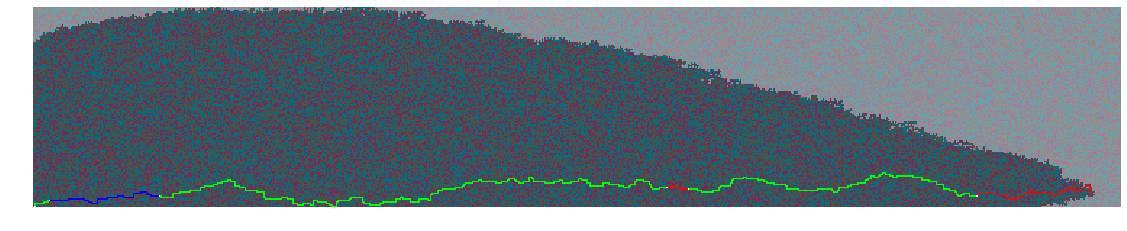

In [25]:
fig, ax = plt.subplots(figsize=(20, bbx*20/bby))
ax.imshow(arr, origin='lower')
plt.axis('off')
plt.savefig('path.png')